# Vytvořte klasifikační model: Lahodné asijské a indické kuchyně


## Klasifikátory kuchyní 1

V této lekci prozkoumáme různé klasifikátory, které nám pomohou *předpovědět národní kuchyni na základě skupiny ingrediencí.* Přitom se dozvíme více o tom, jak lze algoritmy využít pro úkoly klasifikace.

### [**Kvíz před lekcí**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Příprava**

Tato lekce navazuje na naši [předchozí lekci](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), kde jsme:

-   Udělali jemný úvod do klasifikací pomocí datové sady o všech úžasných kuchyních Asie a Indie 😋.

-   Prozkoumali některé [dplyr slovesné funkce](https://dplyr.tidyverse.org/) pro přípravu a čištění dat.

-   Vytvořili krásné vizualizace pomocí ggplot2.

-   Ukázali, jak se vypořádat s nevyváženými daty jejich předzpracováním pomocí [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrovali, jak `prep` a `bake` náš recept, abychom se ujistili, že funguje, jak má.

#### **Předpoklady**

Pro tuto lekci budeme potřebovat následující balíčky pro čištění, přípravu a vizualizaci dat:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) je [kolekce balíčků pro R](https://www.tidyverse.org/packages), která usnadňuje, zrychluje a zpříjemňuje datovou vědu!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) je rámec [kolekce balíčků](https://www.tidymodels.org/packages/) pro modelování a strojové učení.

-   `themis`: [balíček themis](https://themis.tidymodels.org/) poskytuje další kroky pro recepty, které pomáhají řešit nevyvážená data.

-   `nnet`: [balíček nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) poskytuje funkce pro odhadování dopředných neuronových sítí s jednou skrytou vrstvou a pro modely multinomické logistické regrese.

Můžete je nainstalovat jako:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativně níže uvedený skript zkontroluje, zda máte balíčky potřebné k dokončení tohoto modulu, a nainstaluje je za vás, pokud chybí.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



Pojďme na to!

## 1. Rozdělení dat na trénovací a testovací sady.

Začneme tím, že si vybereme několik kroků z naší předchozí lekce.

### Odstraňte nejběžnější ingredience, které způsobují záměnu mezi různými kuchyněmi, pomocí `dplyr::select()`.

Kdo by nemiloval rýži, česnek a zázvor!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


Skvělé! Teď je čas rozdělit data tak, aby 70 % dat bylo použito pro trénink a 30 % pro testování. Při rozdělování také použijeme techniku `stratifikace`, abychom `zachovali poměr jednotlivých kuchyní` v tréninkových a validačních datových sadách.

[rsample](https://rsample.tidymodels.org/), balíček v Tidymodels, poskytuje infrastrukturu pro efektivní rozdělování a resamplování dat:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. Práce s nevyváženými daty

Jak jste si mohli všimnout v původním datovém souboru i v našem trénovacím souboru, existuje poměrně nerovnoměrné rozložení počtu kuchyní. Korejské kuchyně jsou *téměř* třikrát častější než thajské kuchyně. Nevyvážená data často negativně ovlivňují výkon modelu. Mnoho modelů dosahuje nejlepších výsledků, když je počet pozorování vyrovnaný, a proto mají tendenci mít problémy s nevyváženými daty.

Existují dvě hlavní metody, jak pracovat s nevyváženými datovými soubory:

-   přidání pozorování do minoritní třídy: `Over-sampling`, například použitím algoritmu SMOTE, který synteticky generuje nové příklady minoritní třídy na základě nejbližších sousedů těchto případů.

-   odstranění pozorování z majoritní třídy: `Under-sampling`

V naší předchozí lekci jsme ukázali, jak pracovat s nevyváženými datovými soubory pomocí `receptu`. Recept si můžeme představit jako plán, který popisuje, jaké kroky by měly být aplikovány na datový soubor, aby byl připraven pro analýzu dat. V našem případě chceme dosáhnout rovnoměrného rozložení počtu našich kuchyní v `trénovacím souboru`. Pojďme se do toho pustit.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Můžete samozřejmě potvrdit (pomocí přípravy a pečení), že recept bude fungovat podle vašich očekávání - všechny štítky kuchyní mají `559` pozorování.

Protože tento recept budeme používat jako předzpracování pro modelování, `workflow()` za nás provede veškerou přípravu a pečení, takže nebudeme muset recept odhadovat ručně.

Teď jsme připraveni trénovat model 👩‍💻👨‍💻!

## 3. Výběr klasifikátoru

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ilustrace od @allison_horst</figcaption>


Teď musíme rozhodnout, který algoritmus použít pro tento úkol 🤔.

V Tidymodels poskytuje [`parsnip package`](https://parsnip.tidymodels.org/index.html) konzistentní rozhraní pro práci s modely napříč různými enginy (balíčky). Podívejte se na dokumentaci parsnip, kde můžete prozkoumat [typy modelů a enginy](https://www.tidymodels.org/find/parsnip/#models) a jejich odpovídající [argumenty modelů](https://www.tidymodels.org/find/parsnip/#model-args). Na první pohled je ta rozmanitost docela ohromující. Například následující metody zahrnují klasifikační techniky:

-   C5.0 modely založené na pravidlech

-   Flexibilní diskriminační modely

-   Lineární diskriminační modely

-   Regularizované diskriminační modely

-   Modely logistické regrese

-   Modely multinomické regrese

-   Modely naivního Bayese

-   Support Vector Machines

-   Nejbližší sousedé

-   Rozhodovací stromy

-   Ensemble metody

-   Neuronové sítě

A seznam pokračuje dál!

### **Jaký klasifikátor zvolit?**

Takže, který klasifikátor byste měli vybrat? Často je dobré vyzkoušet několik z nich a hledat nejlepší výsledek.

> AutoML tento problém elegantně řeší tím, že provádí tyto porovnání v cloudu, což vám umožní vybrat nejlepší algoritmus pro vaše data. Vyzkoušejte to [zde](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Volba klasifikátoru také závisí na našem problému. Například pokud výsledek může být rozdělen do `více než dvou tříd`, jako v našem případě, musíte použít `algoritmus pro multiklasifikaci` namísto `binární klasifikace.`

### **Lepší přístup**

Lepší způsob než náhodné hádání je však řídit se nápady z tohoto stahovatelného [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Zde zjistíme, že pro náš problém s multiklasifikací máme několik možností:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Část Microsoftova Cheat Sheetu algoritmů, která popisuje možnosti multiklasifikace</figcaption>


### **Úvaha**

Podívejme se, jak můžeme přistoupit k řešení tohoto problému s ohledem na daná omezení:

-   **Hluboké neuronové sítě jsou příliš náročné.** Vzhledem k našemu čistému, ale minimálnímu datasetu a faktu, že trénování probíhá lokálně v noteboocích, jsou hluboké neuronové sítě pro tento úkol příliš těžkopádné.

-   **Nepoužíváme dvoutřídní klasifikátor.** Nepoužíváme dvoutřídní klasifikátor, což vylučuje přístup one-vs-all.

-   **Rozhodovací strom nebo logistická regrese by mohly fungovat.** Rozhodovací strom by mohl být vhodný, stejně jako multinomiální regrese nebo vícetřídní logistická regrese pro vícetřídní data.

-   **Vícetřídní Boosted Decision Trees řeší jiný problém.** Vícetřídní boosted decision tree je nejvhodnější pro neparametrické úlohy, například úlohy zaměřené na tvorbu žebříčků, což pro nás není užitečné.

Obecně platí, že než se pustíme do složitějších modelů strojového učení, jako jsou ensemble metody, je dobré začít s co nejjednodušším modelem, abychom získali základní přehled o datech. Proto v této lekci začneme s modelem `multinomiální regrese`.

> Logistická regrese je technika používaná, když je výstupní proměnná kategoriální (nebo nominální). U binární logistické regrese jsou dvě výstupní proměnné, zatímco u multinomiální logistické regrese je počet výstupních proměnných větší než dvě. Další informace naleznete v [Pokročilé regresní metody](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Trénování a vyhodnocení modelu multinomiální logistické regrese

V Tidymodels funkce `parsnip::multinom_reg()` definuje model, který používá lineární prediktory k predikci vícetřídních dat pomocí multinomiální distribuce. Podívejte se na `?multinom_reg()` pro různé způsoby/enginy, které můžete použít k trénování tohoto modelu.

V tomto příkladu budeme trénovat model multinomiální regrese pomocí výchozího enginu [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Hodnotu `penalty` jsem zvolil spíše náhodně. Existují lepší způsoby, jak tuto hodnotu zvolit, například pomocí `resamplingu` a `ladění` modelu, o kterých budeme hovořit později.
>
> Podívejte se na [Tidymodels: Začínáme](https://www.tidymodels.org/start/tuning/), pokud se chcete dozvědět více o ladění hyperparametrů modelu.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Skvělá práce 🥳! Teď, když máme recept a specifikaci modelu, musíme najít způsob, jak je spojit do jednoho objektu, který nejprve předzpracuje data, poté na těchto předzpracovaných datech nastaví model a zároveň umožní případné aktivity po zpracování. V Tidymodels se tento praktický objekt nazývá [`workflow`](https://workflows.tidymodels.org/) a pohodlně uchovává vaše modelovací komponenty! To je to, co bychom v *Pythonu* nazvali *pipelines*.

Tak pojďme všechno spojit do workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Pracovní postupy 👌👌! **`workflow()`** lze přizpůsobit podobně jako model. Takže je čas vytrénovat model!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Výstup ukazuje koeficienty, které se model naučil během trénování.

### Vyhodnocení natrénovaného modelu

Je čas zjistit, jak si model vedl 📏, a to jeho vyhodnocením na testovací sadě! Začněme tím, že vytvoříme předpovědi na testovací sadě.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


Skvělá práce! V Tidymodels lze hodnocení výkonu modelu provádět pomocí [yardstick](https://yardstick.tidymodels.org/) - balíčku používaného k měření efektivity modelů pomocí metrik výkonu. Jak jsme to udělali v naší lekci o logistické regresi, začněme výpočtem matice záměn.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Při práci s více třídami je obecně intuitivnější si to představit jako tepelnou mapu, takto:


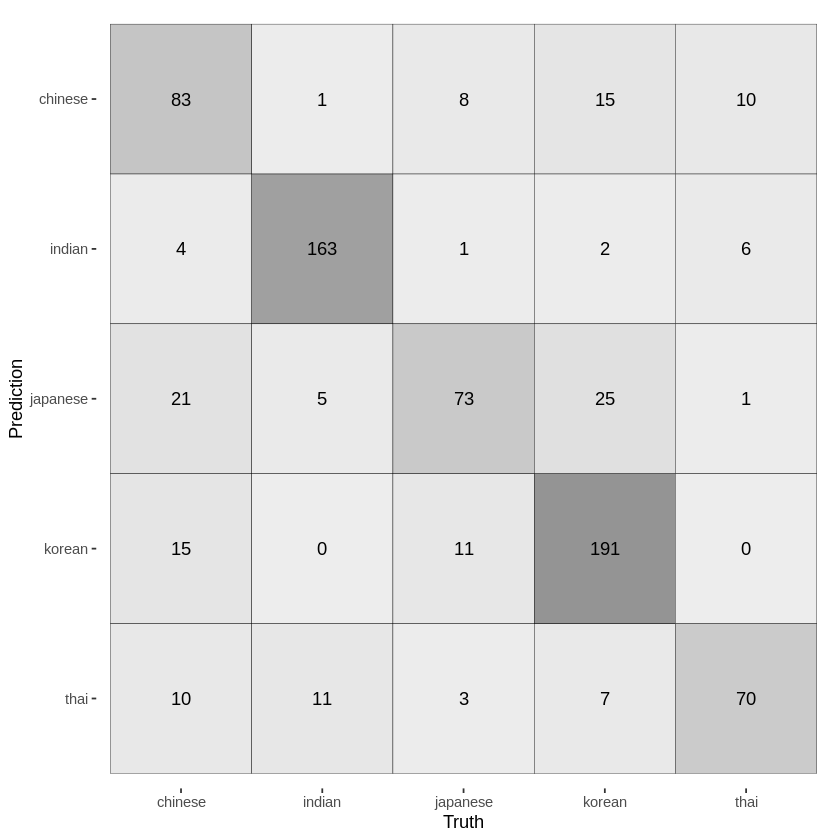

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Tmavší čtverce v grafu matice záměn označují vysoký počet případů a pravděpodobně vidíte diagonální linii tmavších čtverců, která ukazuje případy, kdy se předpovězený a skutečný štítek shodují.

Nyní spočítejme souhrnné statistiky pro matici záměn.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


Pokud se zaměříme na některé metriky, jako je přesnost, citlivost, ppv, na začátek na tom nejsme špatně 🥳!

## 4. Jdeme hlouběji

Položme si jednu jemnou otázku: Jaká kritéria se používají k určení konkrétního typu kuchyně jako předpovězeného výsledku?

Statistické algoritmy strojového učení, jako je logistická regrese, jsou založeny na `pravděpodobnosti`; takže to, co klasifikátor skutečně předpovídá, je pravděpodobnostní rozdělení nad množinou možných výsledků. Třída s nejvyšší pravděpodobností je pak vybrána jako nejpravděpodobnější výsledek pro daná pozorování.

Podívejme se na to v praxi tím, že provedeme jak tvrdé předpovědi tříd, tak pravděpodobnosti.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


✅ Můžete vysvětlit, proč si model je téměř jistý, že první pozorování je thajské?

## **🚀Výzva**

V této lekci jste použili svá vyčištěná data k vytvoření modelu strojového učení, který dokáže předpovědět národní kuchyni na základě série ingrediencí. Udělejte si čas na prozkoumání [mnoha možností](https://www.tidymodels.org/find/parsnip/#models), které Tidymodels nabízí pro klasifikaci dat, a [dalších způsobů](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models), jak použít multinomickou regresi.

#### DĚKUJEME:

[`Allison Horst`](https://twitter.com/allison_horst/) za vytvoření úžasných ilustrací, které dělají R přívětivějším a poutavějším. Další ilustrace najdete v její [galerii](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) a [Jen Looper](https://www.twitter.com/jenlooper) za vytvoření původní verze tohoto modulu v Pythonu ♥️

<br>
Chtěl bych přidat nějaké vtipy, ale nerozumím slovním hříčkám o jídle 😅.

<br>

Šťastné učení,

[Eric](https://twitter.com/ericntay), Zlatý ambasador Microsoft Learn Student.



---

**Prohlášení**:  
Tento dokument byl přeložen pomocí služby pro automatický překlad [Co-op Translator](https://github.com/Azure/co-op-translator). Ačkoli se snažíme o přesnost, mějte prosím na paměti, že automatické překlady mohou obsahovat chyby nebo nepřesnosti. Původní dokument v jeho původním jazyce by měl být považován za závazný zdroj. Pro důležité informace doporučujeme profesionální lidský překlad. Neneseme odpovědnost za jakékoli nedorozumění nebo nesprávné interpretace vyplývající z použití tohoto překladu.
